## Instalare si importare biblioteci

Prima data, am instalat si importat pachetele necesare: PyOD pentru modelele de detectare a anomaliilor, ucimlrepo pentru setul de date si biblioteci pentru preprocesarea si evaluarea performantelor.

In [75]:
!pip install pyod ucimlrepo

from ucimlrepo import fetch_ucirepo
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import matplotlib.pyplot as plt

## Incarcare set de date

Setul de date [Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) contine informatii despre factori de risc pentru bolile cardiovasculare, precum varsta, sexul, colesterolul si tensiunea arteriala. In codul de mai jos, am utilizat **fetch_ucirepo(id=45)** pentru a incarca setul de date, **X** continand caracteristicile (factorii de risc), iar **y** etichetele (diagnosticul). Dupa, am afisat metadatele si informatiile despre variabile pentru a intelege structura datelor, impreuna cu primele 5 intrari.

Tipuri de anomalii: **locale** (puncte cu valori extreme pentru variabilele de risc) si **de tip cluster** (grupuri de pacienti cu combinatii neobisnuite de factori de risc).

In [76]:
heart_disease=fetch_ucirepo(id=45)
X=heart_disease.data.features
y=heart_disease.data.targets

print("Metadate:",heart_disease.metadata)
print("\nInformatii feature-uri:\n",heart_disease.variables,"\n")
X.head()

Metadate: {'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Ste

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


## Explorare date

Am afisat distributia variabilelor din setul de date folosind histograme, pentru a observa modul in care valorile sunt distribuite pe fiecare caracteristica.

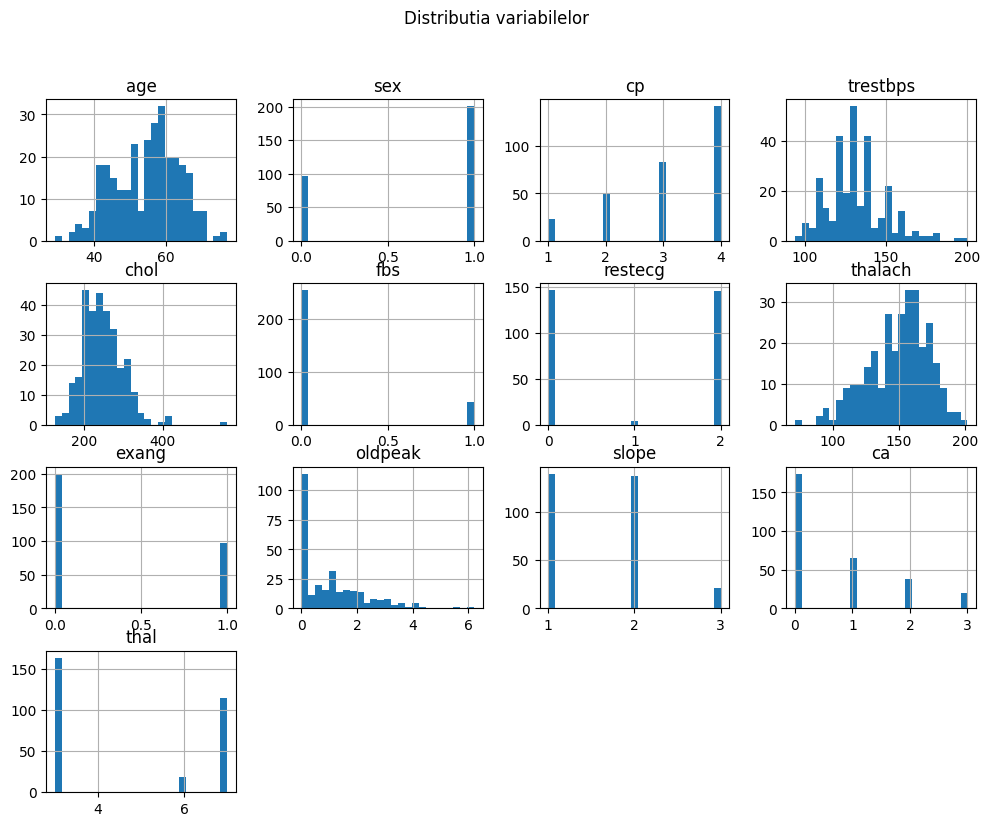

In [92]:
X.hist(figsize=(12,9),bins=25)
plt.suptitle('Distributia variabilelor')
plt.show()

## Preprocesare date

Am verificat si eliminat valorile lipsa din setul de date, am normalizat datele folosind **StandardScaler**, si am aplicat PCA pentru a reduce dimensiunea datelor la 2 componente cu scopul de a facilita vizualizarea (dar in antrenare si testare am folosit datele care nu au fost reduse). Datele sunt impartite in seturi de antrenare si test utilizand **train_test_split**, iar in final, se afiseaza dimensiunile seturilor de date pentru a verifica corectitudinea prelucrarii.

In [77]:
print("Valori lipsa in setul de date:")
print(X.isnull().sum())
X=X.dropna()
y=y.loc[X.index]

X_scaled=StandardScaler().fit_transform(X)
pca=PCA(n_components=2)
X_scaled_2d=pca.fit_transform(X_scaled)
y_binary=(y.to_numpy().ravel()>0).astype(int)

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_binary,test_size=0.2,random_state=42)
X_train_2d=pca.transform(X_train)
X_test_2d=pca.transform(X_test)
print("\nForma set de antrenare:",X_train.shape)
print("Forma set de test:",X_test.shape)

Valori lipsa in setul de date:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Forma set de antrenare: (237, 13)
Forma set de test: (60, 13)


## Vizualizare date preprocesate

Setul de date este vizualizat in 2D dupa aplicarea PCA, folosind cele doua componente principale. Punctele sunt colorate in functie de etichetele binare **y_binary**, unde albastru reprezinta cazurile normale si rosu cele bolnave, pentru a observa distributia si posibilele anomalii.

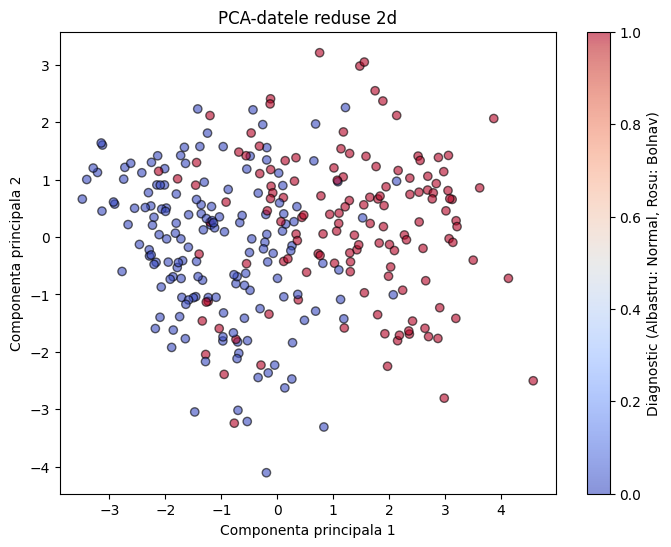

In [78]:
plt.figure(figsize=(8,6))
plt.scatter(X_scaled_2d[:,0],X_scaled_2d[:,1],c=y_binary,cmap='coolwarm',edgecolors='k',alpha=0.6)
plt.xlabel("Componenta principala 1")
plt.ylabel("Componenta principala 2")
plt.title("PCA-datele reduse 2d")
plt.colorbar(label="Diagnostic (Albastru: Normal, Rosu: Bolnav)")
plt.show()

## Implementare modele de detectie a anomaliilor

### KNN (K-Nearest Neighbors)

Se antreneaza un model **KNN** pentru detectarea anomaliilor folosind parametrii **contamination=0.45** (45% anomalii), **n_neighbors=4** (4 vecini) si **method='largest'**. **KNN** detecteaza anomaliile prin calcularea distantei fata de cei mai apropiati vecini: punctele cu distante mari sunt considerate anomalii. Modelul este antrenat pe setul de antrenare si apoi face predictii atat pe setul de antrenare, cat si pe cel de test.

In [79]:
knn=KNN(contamination=0.45,n_neighbors=4,method='largest')
knn.fit(X_train)

y_train_scores_knn=knn.decision_function(X_train)
y_train_pred_knn=knn.predict(X_train)
y_test_scores_knn=knn.decision_function(X_test)
y_test_pred_knn=knn.predict(X_test)

### ABOD (Angle-Based Outlier Detection)

Se antreneaza un model **ABOD** pentru detectarea anomaliilor folosind parametrii **contamination=0.45** si **n_neighbors=4**. **ABOD** detecteaza anomaliile prin calcularea unghiurilor dintre vectori: punctele care formeaza unghiuri mari fata de vecinii lor sunt considerate anomalii.

In [80]:
abod=ABOD(contamination=0.45,n_neighbors=4)
abod.fit(X_train)

y_train_scores_abod=abod.decision_function(X_train)
y_train_pred_abod=abod.predict(X_train)
y_test_scores_abod=abod.decision_function(X_test)
y_test_pred_abod=abod.predict(X_test)

### IForest (Isolation Forest)

Se antreneaza un model **IForest** pentru detectarea anomaliilor folosind parametrii **n_estimators=150** (150 de arbori) si **contamination=0.45**. **IForest** detecteaza anomaliile prin izolarea punctelor care sunt mai usor de separat de restul datelor, utilizand arbori de decizie: punctele care sunt izolate rapid sunt considerate anomalii.

In [81]:
iforest=IForest(n_estimators=150,contamination=0.45)
iforest.fit(X_train)

y_train_scores_iforest=iforest.decision_function(X_train)
y_train_pred_iforest=iforest.predict(X_train)
y_test_scores_iforest=iforest.decision_function(X_test)
y_test_pred_iforest=iforest.predict(X_test)

### OCSVM (One-Class SVM)

Se antreneaza un model **OCSVM** pentru detectarea anomaliilor folosind parametrii **kernel='linear'** si **contamination=0.45**. **OCSVM** detecteaza anomaliile prin crearea unei margini care separa datele normale de cele anormale: punctele care se afla in afara acestei margini sunt considerate anomalii.

In [82]:
ocsvm=OCSVM(kernel='linear',contamination=0.45)
ocsvm.fit(X_train)

y_train_scores_ocsvm=ocsvm.decision_function(X_train)
y_train_pred_ocsvm=ocsvm.predict(X_train)
y_test_scores_ocsvm=ocsvm.decision_function(X_test)
y_test_pred_ocsvm=ocsvm.predict(X_test)

## Evaluare si vizualizare rezultate

### KNN (K-Nearest Neighbors)

Modelul **KNN** a fost evaluat pe seturile de antrenare si testare, obtinand **ROC** (Receiver Operating Characteristic), care indica o performanta buna in detectarea anomaliilor, iar **precision @ rank n** sugereaza o precizie decenta. **Scorul Silueta** mic indica o separare slaba a clusterelelor, iar **scorul de coerenta** sugereaza o separare mai buna in setul de antrenare.

Evaluare KNN:
Train ROC:0.5928, precision @ rank n:0.5133
Scor Silueta train: 0.08322026008598453
Scor de coerenta train: 13.11078553735412
Test ROC:0.7245, precision @ rank n:0.5833
Scor Silueta test: 0.14601763702974369
Scor de coerenta test: 6.209734865824513


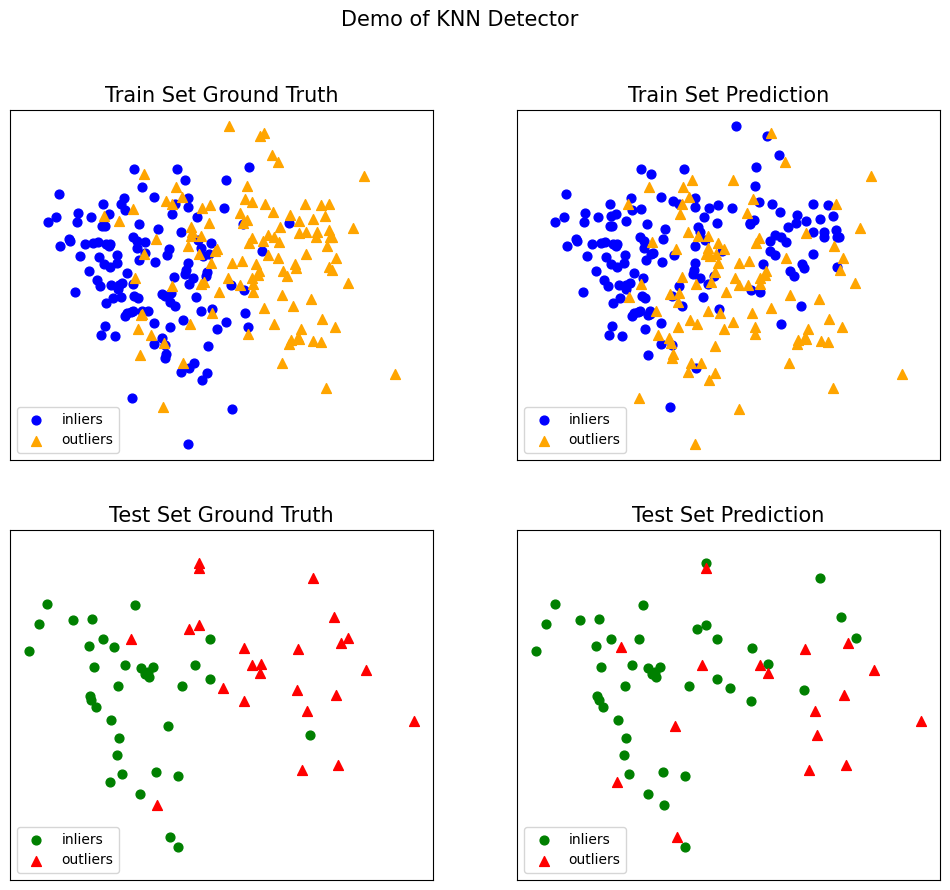

In [83]:
print("Evaluare KNN:")
evaluate_print("Train",y_train,y_train_scores_knn)
print("Scor Silueta train:",silhouette_score(X_train,y_train_pred_knn))
print("Scor de coerenta train:",calinski_harabasz_score(X_train,y_train_pred_knn))
evaluate_print("Test",y_test,y_test_scores_knn)
print("Scor Silueta test:",silhouette_score(X_test,y_test_pred_knn))
print("Scor de coerenta test:",calinski_harabasz_score(X_test,y_test_pred_knn))

visualize("KNN",X_train_2d,y_train,X_test_2d,y_test,y_train_pred_knn,y_test_pred_knn,show_figure=True,save_figure=False)

### ABOD (Angle-Based Outlier Detection)

Comparativ cu **KNN**, **ABOD** are un comportament asemanator, cu performante similare pe setul de antrenare, dar cu o scadere a performantelor pe test, avand un **scor de coerenta** mai mic si un **scor Silueta** mic.

Evaluare ABOD:
Train ROC:0.5632, precision @ rank n:0.5398
Scor Silueta train: 0.028588519474831077
Scor de coerenta train: 7.395178345384884
Test ROC:0.691, precision @ rank n:0.5833
Scor Silueta test: 0.06501424116647399
Scor de coerenta test: 3.786749622462924


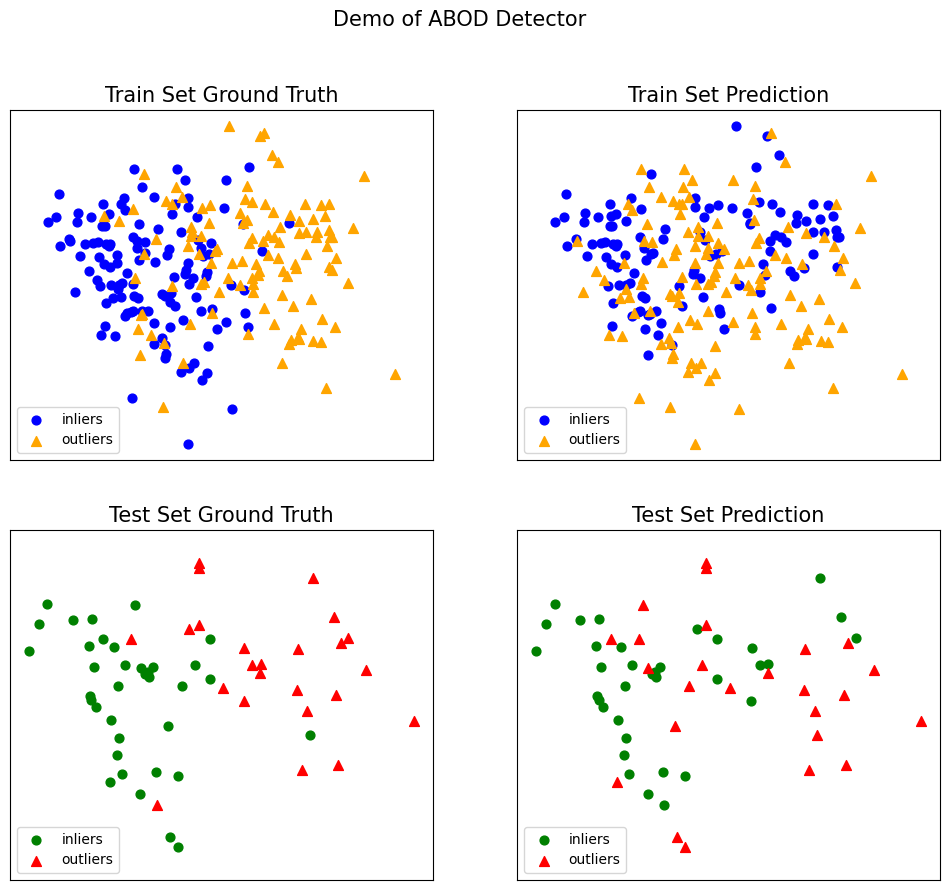

In [84]:
print("Evaluare ABOD:")
evaluate_print("Train",y_train,y_train_scores_abod)
print("Scor Silueta train:",silhouette_score(X_train,y_train_pred_abod))
print("Scor de coerenta train:",calinski_harabasz_score(X_train,y_train_pred_abod))
evaluate_print("Test",y_test,y_test_scores_abod)
print("Scor Silueta test:",silhouette_score(X_test,y_test_pred_abod))
print("Scor de coerenta test:",calinski_harabasz_score(X_test,y_test_pred_abod))

visualize("ABOD",X_train_2d,y_train,X_test_2d,y_test,y_train_pred_abod,y_test_pred_abod,show_figure=True,save_figure=False)

### IForest (Isolation Forest)

Comparativ cu **KNN**, **IForest** are un comportament similar, cu performante bune pe setul de test, dar cu un **scor Silueta** mic. **Scorul de coerenta** sugereaza o performanta mai buna in antrenare, dar o scadere pe test, similar cu **ABOD**.

Evaluare IForest:
Train ROC:0.5921, precision @ rank n:0.5221
Scor Silueta train: 0.07103706329485483
Scor de coerenta train: 12.192581517276006
Test ROC:0.6771, precision @ rank n:0.5833
Scor Silueta test: 0.0657840685752374
Scor de coerenta test: 3.3679480349104165


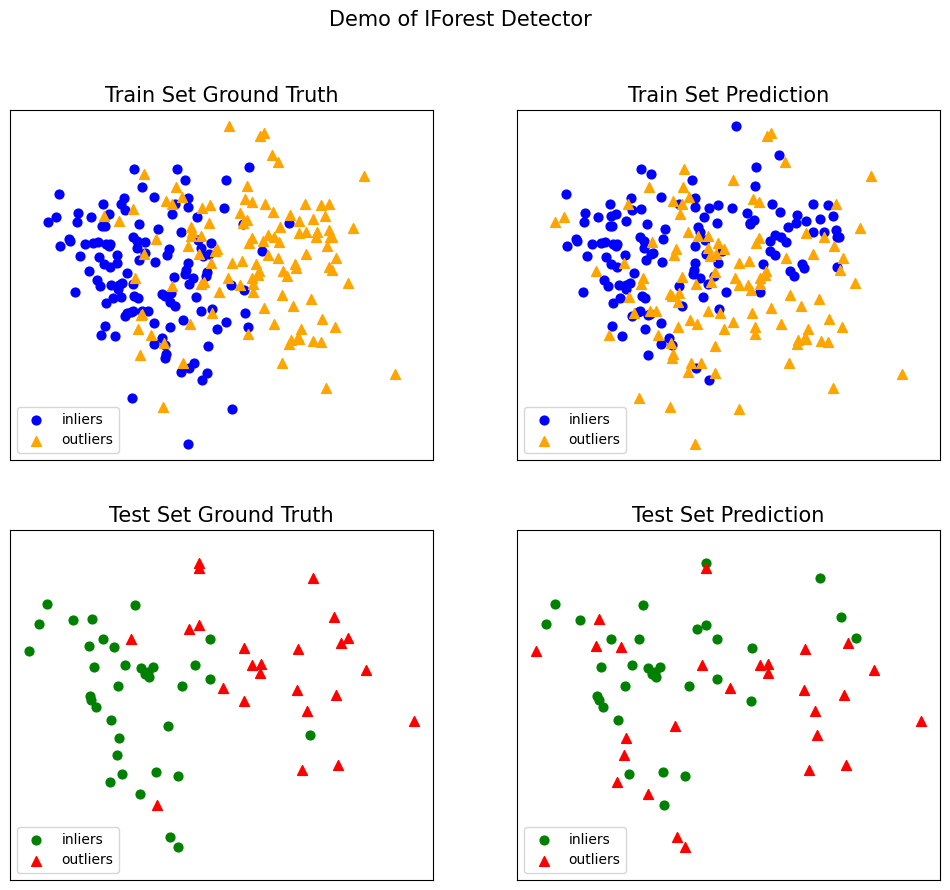

In [85]:
print("Evaluare IForest:")
evaluate_print("Train",y_train,y_train_scores_iforest)
print("Scor Silueta train:",silhouette_score(X_train,y_train_pred_iforest))
print("Scor de coerenta train:",calinski_harabasz_score(X_train,y_train_pred_iforest))
evaluate_print("Test",y_test,y_test_scores_iforest)
print("Scor Silueta test:",silhouette_score(X_test,y_test_pred_iforest))
print("Scor de coerenta test:",calinski_harabasz_score(X_test,y_test_pred_iforest))

visualize("IForest",X_train_2d,y_train,X_test_2d,y_test,y_train_pred_iforest,y_test_pred_iforest,show_figure=True,save_figure=False)

### OCSVM (One-Class SVM)

Comparativ cu celelalte modele, **OCSVM** are performante mai bune pe ambele seturi. **Scorul Silueta** este tot mic, dar **scorul de coerenta** sugereaza o separare buna a datelor in antrenare, cu o performanta mai scazuta pe test.

Evaluare OCSVM:
Train ROC:0.8636, precision @ rank n:0.7965
Scor Silueta train: 0.13284002328847494
Scor de coerenta train: 36.102955402320134
Test ROC:0.8808, precision @ rank n:0.7083
Scor Silueta test: 0.13397309569419
Scor de coerenta test: 9.397406873171768


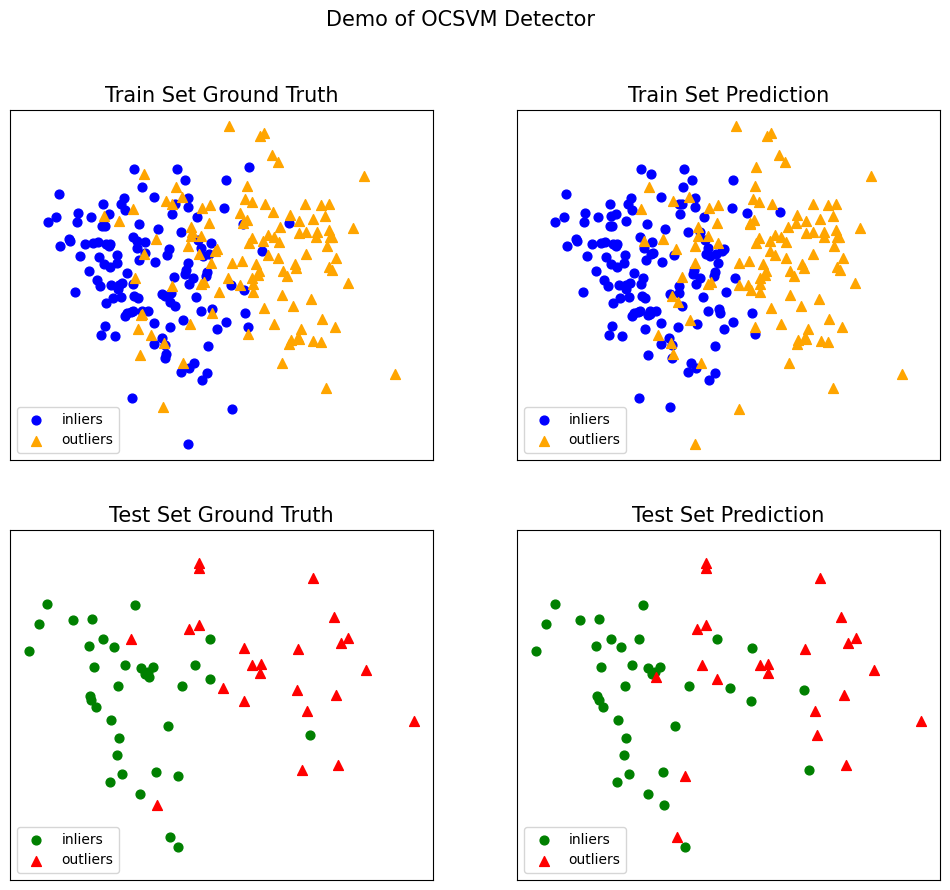

In [86]:
print("Evaluare OCSVM:")
evaluate_print("Train",y_train,y_train_scores_ocsvm)
print("Scor Silueta train:",silhouette_score(X_train,y_train_pred_ocsvm))
print("Scor de coerenta train:",calinski_harabasz_score(X_train,y_train_pred_ocsvm))
evaluate_print("Test",y_test,y_test_scores_ocsvm)
print("Scor Silueta test:",silhouette_score(X_test,y_test_pred_ocsvm))
print("Scor de coerenta test:",calinski_harabasz_score(X_test,y_test_pred_ocsvm))

visualize("OCSVM",X_train_2d,y_train,X_test_2d,y_test,y_train_pred_ocsvm,y_test_pred_ocsvm,show_figure=True,save_figure=False)

**OCSVM** este cel mai bun model datorita performantelor excelente pe setul de test, cu un **ROC** de 0.8808 si un **precision @ rank n** de 0.7083. Kernelul liniar este eficient pentru setul de date **Heart Disease** deoarece datele sunt relativ bine separate si urmeaza un pattern liniar sau aproape liniar. **OCSVM** cu kernel liniar este capabil sa gaseasca marginea de separare intre clase, oferind o detectie mai precisa a anomaliilor.